# Label Noise and the Spectral Bias

In this notebook, we study the effect of label noise frequency has on the learning process. One typically assumes the scenario where:
$$
y = \tau_{0}(x) + \psi
$$
where $\tau_0$ is the true target function and $\psi$ is sampled i.i.d from some distribution (e.g. gaussian). However, $\psi$ can also be interpreted as a realization of white-noise process (or a _random shock_), i.e. as $\psi(\mathbf{x})$. In expectation the spectral density of $\psi$ is constant, i.e. 
$$\mathbb E |\tilde \psi (\mathbf k) | = const$$
In this notebook, we study what happens if this assumption is relaxed. We find that the learning is harshly affected if $\psi$ is a low frequency function. 

Skip to the section **Play** to try your own experiments.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets

from argparse import Namespace

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Data Logistics

In [8]:
def ift(k, x, A=None, phi=None, normalize=True):
    if phi is None: 
        phi = torch.zeros(k.shape[0], dtype=k.dtype, device=k.device)
    if A is None: 
        A = torch.ones(k.shape[0], dtype=k.dtype, device=k.device)
    if normalize: 
        A = A/A.sum()
    _2PI = np.pi * 2
    return (torch.sin_(_2PI * k @ x.t() + phi[:, None]) * A[:, None]).sum(0)

def make_mnist(opt):
    if opt.FMNIST:
        mnist = datasets.FashionMNIST('../fmnist', download=True)
    else:
        mnist = datasets.MNIST('..', download=False)
    X = mnist.train_data.float().div_(255.)
    X = X.view(X.shape[0], 784)
    Y = torch.zeros((X.shape[0], 10), dtype=X.dtype, device=X.device)
    Y[list(range(X.shape[0])), mnist.train_labels] = 1.
    if opt.MASK_CLASSES is not None: 
        mask = (mnist.train_labels.eq(opt.MASK_CLASSES[0]) + mnist.train_labels.eq(opt.MASK_CLASSES[1])).gt(0)
        X = X[mask]
        Y = Y[mask]
    return X, Y

def binarize_mnist(opt, X, Y):
    if opt.MASK_CLASSES is not None:
        Y[:, opt.MASK_CLASSES[0]] *= -1
        Y = Y.sum(-1)
    return X, Y

def get_noise(opt, X, Y, K=None): 
    if K is None:
        # The following samples random unit vectors.
        K = torch.rand(opt.NUM_K, X.shape[1])
        K = K / torch.norm(K, dim=1, keepdim=True)
        K.mul_(opt.NORM_K)
    if opt.RAND_PHASE: 
        phi = torch.rand(K.shape[0])
    else:
        phi = None
    # Compute Sinusoid
    Z = ift(K, X, phi=phi)
    return Z, K

def get_principal_noise(opt, X, Y): 
    # Compute PCA of X
    covX = np.cov(X.numpy().T)
    eigvals, eigvecs = np.linalg.eig(covX)
    # Select the largest components
    K = torch.from_numpy(eigvecs[:, 0:opt.NUM_PCA_COMPS].T.real.astype('float32'))
    # Scale
    K.mul_(opt.NORM_K)
    return get_noise(opt, X, Y, K)

def get_radial_noise(opt, X, Y): 
    Z = torch.sin(2 * np.pi * opt.NORM_K * torch.norm(X, dim=1))
    return Z, opt.NORM_K

def noise_labels(opt, X, Y, K=None, return_K=False): 
    if opt.NUM_PCA_COMPS is not None:
        Z, K = get_principal_noise(opt, X, Y)
    elif opt.NUM_K is not None:
        Z, K = get_noise(opt, X, Y, K)
    else:
        Z, K = get_radial_noise(opt, X, Y)
    Y = Y + opt.AMP_Z * Z
    if return_K: 
        return X, Y, K
    else:
        return X, Y

def get_mnist(opt, val=False, noise_train=True): 
    X, Y = make_mnist(opt)
    X, Y = binarize_mnist(opt, X, Y)
    if not val: 
        stop = int(opt.VAL_SPLIT * X.shape[0])
        X = X[:stop]
        Y = Y[:stop]
        if noise_train:
            X, Y = noise_labels(opt, X, Y)
    else:
        start = int(opt.VAL_SPLIT * X.shape[0])
        X = X[start:]
        Y = Y[start:]
    return X, Y

## Model Training

In [9]:
def make_model(opt):
    layers = []
    layers.append(nn.Linear(opt.INP_DIM, opt.WIDTH))
    layers.append(nn.ReLU())
    for _ in range(opt.DEPTH - 2): 
        layers.append(nn.Linear(opt.WIDTH, opt.WIDTH))
        layers.append(nn.ReLU())
    layers.extend([nn.Linear(opt.WIDTH, opt.OUT_DIM)])
    model = nn.Sequential(*layers)
    if opt.CUDA:
        model = model.cuda()
    return model

In [10]:
def train_model(opt, model, input_, target, val_input_, val_target):
    # Build loss
    loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
        val_input_ = val_input_.cuda()
        val_target = val_target.cuda()
    # Loop! 
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        y = model(x)
        loss = loss_fn(y, yt)
        loss.backward()
        optim.step()
        if iter_num % opt.REC_FRQ == 0: 
            # Validate
            with torch.no_grad(): 
                x = val_input_
                yt = val_target.view(-1, opt.OUT_DIM)
                y = model(x)
                val_loss = loss_fn(y, yt)
            frames.append(Namespace(iter_num=iter_num, 
                                    # prediction=y.data.cpu().numpy(), 
                                    loss=loss.item(), 
                                    val_loss=val_loss.item()))
    # Done
    model.eval()
    return frames

## Plotting

In [11]:
font = {'size'   : 30}

SIZE = 15

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=SIZE)
matplotlib.rc('ytick', labelsize=SIZE)
matplotlib.rc('axes', labelsize=SIZE, titlesize=SIZE)
matplotlib.rc('legend', fontsize=SIZE)

In [12]:
def plot_loss(frames): 
    its, val_loss, tr_loss = zip(*[(frame.iter_num, frame.val_loss, frame.loss) for frame in frames])
    plt.figure()
    plt.semilogy(its, tr_loss, label='Training')
    plt.semilogy(its, val_loss, label='Validation')
    plt.xlabel("Training Iteration")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()
    
def compare_loss(frames0, frames1): 
    its, val_loss0 = zip(*[(frame.iter_num, frame.val_loss) for frame in frames0])
    its, val_loss1 = zip(*[(frame.iter_num, frame.val_loss) for frame in frames1])
    plt.figure()
    plt.semilogy(its, val_loss0, label='Set 0')
    plt.semilogy(its, val_loss1, label='Set 1')
    plt.xlabel("Training Iteration")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

## Play

In [13]:
opt = Namespace()

In [14]:
# Data Generation
opt.MASK_CLASSES = [3, 8]    # <--- Select a dataset, could be [0, 1], [3, 9], ...
opt.NUM_PCA_COMPS = None     # <--- Num PCA components to use for PCA-Noise
opt.NUM_K = None             # <--- Number of unit frequency vectors to sample (on a 784D sphere)
opt.NORM_K = 0.1             # <--- Norm of the frequency vector
opt.RAND_PHASE = False       # <--- Whether to use random phase for the sinusoids
opt.AMP_Z = 1.               # <--- Amplitude of noise
opt.VAL_SPLIT = 0.8          # <--- What percent of data to use for training
opt.FMNIST = False           # <--- Whether to use Fashion-MNIST
# Model Definition
opt.INP_DIM = 784            # <--- Input dim of the network. (leave this alone for MNIST)
opt.OUT_DIM = 1              # <--- Number of network outputs. (leave this alone for MNIST)
opt.DEPTH = 6                # <--- Depth of the network.
opt.WIDTH = 256              # <--- Width of layers. 
opt.CUDA = True              # <--- Whether to use CUDA
# Model Training
opt.LR = 0.0001              # <--- LR for the optimizer. 
opt.NUM_ITER = 5000          # <--- Number of training iterations
opt.REC_FRQ = 1              # <--- How often to record stats (leave this alone). 

In [15]:
tX, tY = get_mnist(opt, val=False, noise_train=True)
vX, vY = get_mnist(opt, val=True)

The "3"s are mapped to -1, whereas the "8"s to +1. 

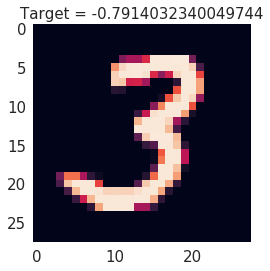

In [16]:
# Change this if you please:
PLOT_IDX = 42

plt.figure()
plt.title(f"Target = {tY[PLOT_IDX].item()}")
plt.imshow(tX[PLOT_IDX].view(28, 28).numpy())
plt.grid(False)
plt.show()

In [17]:
def go(opt): 
    tX, tY = get_mnist(opt, val=False, noise_train=True)
    vX, vY = get_mnist(opt, val=True)
    model = make_model(opt)
    frames = train_model(opt, model, tX, tY, vX, vY)
    return frames

In [18]:
framelib = {}

### No Noise (Baseline)

In [19]:
opt.NORM_K = 1.
opt.AMP_Z = 0.    # <--- No noise.
framelib[opt.NORM_K, opt.AMP_Z] = go(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

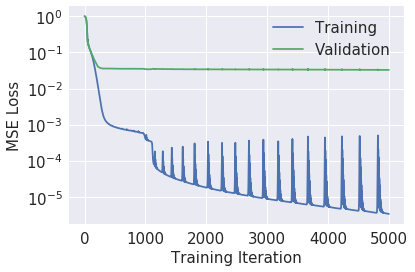

In [20]:
plot_loss(framelib[opt.NORM_K, opt.AMP_Z])

### Very Low Frequency Noise

In [21]:
opt.NORM_K = 0.05
opt.AMP_Z = 1.
framelib[opt.NORM_K, opt.AMP_Z] = go(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

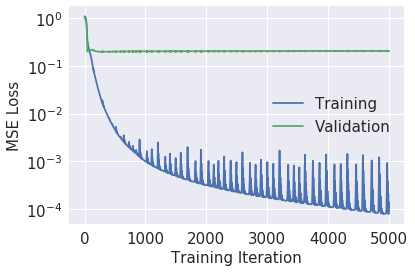

In [22]:
plot_loss(framelib[opt.NORM_K, opt.AMP_Z])

The performance is rekt, and the validation loss tanks at around 0.2. Let's increase the frequency a little. 

### Low Frequency Noise

In [35]:
opt.NORM_K = 0.2
opt.AMP_Z = 1.
framelib[opt.NORM_K, opt.AMP_Z] = go(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

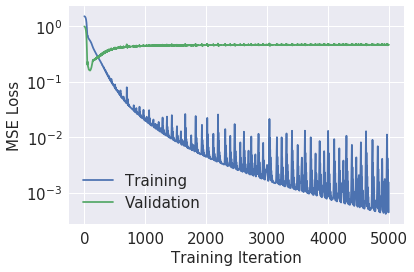

In [36]:
plot_loss(framelib[opt.NORM_K, opt.AMP_Z])

A bit better. We already see a little "dip" in the validation score early in the training, after which the validation loss increases (but the training loss keeps sinking). The increase in loss is because the network gradually learns the slightly higher frequency noise signal. Let's keep increasing the frequency. 

### High Frequency Noise

In [33]:
opt.NORM_K = 1.
opt.AMP_Z = 1.
framelib[opt.NORM_K, opt.AMP_Z] = go(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

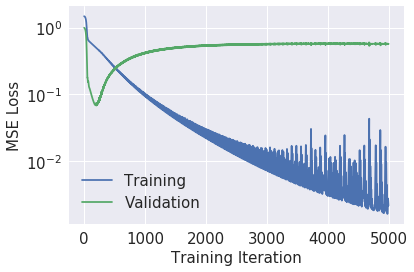

In [34]:
plot_loss(framelib[opt.NORM_K, opt.AMP_Z])

The dip is pretty apparent now. Observe that the best validation loss is what approximately what the network gets without noise; meaning at the dip, the network has almost learned the true target function $\tau_0$, before it goes on to fit the high frequency noise. In the next experiment, we push it further. 

## Choose Your Adventure

In [76]:
opt.MASK_CLASSES = [3, 8]    # <--- Change dataset (e.g. [0, 1], [4, 9])
opt.NORM_K = 1.   # <--- Change noise frequency 
opt.AMP_Z = 1.    # <--- Change noise amplitude
frames = go(opt)

In [77]:
plot_loss(frames)